# Imports

In [13]:
# %pip install torchtext==0.6.0

In [14]:
import torchtext

In [15]:
print(torchtext.__version__)

0.6.0


In [16]:
# %pip install torch==2.3.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [18]:
# %pip install matplotlib

In [19]:
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer
from torchtext.data import Field, TabularDataset, BucketIterator
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [20]:
#%pip install spacy

In [21]:
import spacy

In [22]:
print(torch.__version__)

2.3.0+cu121


In [23]:
torch.backends.cudnn.deterministic = True

In [35]:
path = '/Sentiment Analysis'

# Settings

In [41]:
parameters = {
    "random_state": 1000,
    "VOCABULARY_SIZE": 20000,
    "LEARNING_RATE": 0.005, #0.01, #0.001,
    "BATCH_SIZE": 128, #50,
    "NUM_EPOCHS": 1,
    "DEVICE": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "EMBEDDING_DIM": 100, # GloVe embedding dimension
    "HIDDEN_DIM": 256, #512, #320, 
    "NUM_CLASSES": 1,
    "NUM_HIDDEN_LAYERS": 2,
    "DROPOUT": 0.5, #0.3,
    "CLIP": 1,
    "STEP_SIZE": 1,  #2,
    "GAMMA": 0.1 #0.2
}
torch.manual_seed(parameters['random_state'])

In [20]:
parameters['DEVICE']

device(type='cuda')

# GloVe

In [42]:
# Define tokenizer
tokenizer = get_tokenizer("basic_english")

# Load GloVe embeddings
glove = GloVe(name='6B', dim=100)

# Define Fields for data preprocessing
TEXT = Field(tokenize=tokenizer, lower=True)
# LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)
LABEL = Field(sequential=False, use_vocab=True, dtype=torch.float)  # Change use_vocab to True


# Define fields in the dataset
fields = [('review', TEXT), ('sentiment', LABEL)]

# Load dataset
train_data, test_data = TabularDataset.splits(
    path='/Sentiment Analysis',
    train='amazon_train.csv',
    test='amazon_test.csv',
    format='csv',
    fields=fields
)

# Build vocab using pretrained GloVe embeddings
TEXT.build_vocab(train_data, max_size = parameters['VOCABULARY_SIZE'], vectors=glove)
LABEL.build_vocab(train_data)


In [43]:
i = 0
for example in train_data:
    print(vars(example))
    i+=1
    if i>5:
        break

{'review': ['review'], 'sentiment': 'sentiment'}
{'review': ['this', 'sound', 'track', 'was', 'beautiful', '!', 'it', 'paints', 'the', 'senery', 'in', 'your', 'mind', 'so', 'well', 'i', 'would', 'recomend', 'it', 'even', 'to', 'people', 'who', 'hate', 'vid', '.', 'game', 'music', '!', 'i', 'have', 'played', 'the', 'game', 'chrono', 'cross', 'but', 'out', 'of', 'all', 'of', 'the', 'games', 'i', 'have', 'ever', 'played', 'it', 'has', 'the', 'best', 'music', '!', 'it', 'backs', 'away', 'from', 'crude', 'keyboarding', 'and', 'takes', 'a', 'fresher', 'step', 'with', 'grate', 'guitars', 'and', 'soulful', 'orchestras', '.', 'it', 'would', 'impress', 'anyone', 'who', 'cares', 'to', 'listen', '!', '^_^'], 'sentiment': '1'}
{'review': ['i', "'", 'm', 'reading', 'a', 'lot', 'of', 'reviews', 'saying', 'that', 'this', 'is', 'the', 'best', "'", 'game', 'soundtrack', "'", 'and', 'i', 'figured', 'that', 'i', "'", 'd', 'write', 'a', 'review', 'to', 'disagree', 'a', 'bit', '.', 'this', 'in', 'my', 'opin

In [44]:
def data_loader(train_data, test_data, parameters):
    
    train_data, validation_data = train_data.split(split_ratio = [0.7, 0.3],
                                     random_state = random.seed(parameters['random_state']))
    
    train_loader, validation_loader, test_loader = torchtext.data.BucketIterator.splits(
        (train_data, validation_data, test_data), 
        batch_size = parameters['BATCH_SIZE'], 
        sort_within_batch = False, sort_key = lambda x: len(x.review), 
        device = parameters['DEVICE']
    )

    return train_loader, validation_loader, test_loader


In [45]:
train_loader, validation_loader, test_loader = data_loader(train_data, test_data, parameters)

In [46]:
# Print a batch from train_loader
for batch in train_loader:
    print("train_loader:\n\n", vars(batch))
    break

# Print a batch from validation_loader
for batch in validation_loader:
    print("validation_loader:\n\n", vars(batch))
    break

# Print a batch from test_loader
for batch in test_loader:
    print("test_loader:\n\n", vars(batch))
    break


train_loader:

 {'batch_size': 128, 'dataset': <torchtext.data.dataset.Dataset object at 0x000002B3564A4F50>, 'fields': dict_keys(['review', 'sentiment']), 'input_fields': ['review', 'sentiment'], 'target_fields': [], 'review': tensor([[ 673, 1611,   12,  ...,   12, 7417,   57],
        [  20, 4570, 2304,  ..., 1236, 3496,   51],
        [  19, 2649,   13,  ...,  943,    6,  886],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0'), 'sentiment': tensor([1., 2., 1., 1., 2., 2., 2., 1., 2., 1., 1., 1., 2., 1., 2., 2., 1., 1.,
        1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2.,
        1., 2., 1., 2., 1., 2., 1., 2., 2., 2., 2., 1., 1., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 2., 1., 2., 1., 2., 1., 2., 2., 2., 1., 1., 2., 1., 2.,
        1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 2., 2., 1., 1., 2., 1., 2., 2.,
        1., 2.,

* TODO: Play around really

# RNN Class

In [16]:
class RNN(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.num_layers = num_layers
        self.lstms = torch.nn.ModuleList([torch.nn.LSTM(embedding_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output = embedded
        for lstm in self.lstms:
            output, (hidden, cell) = lstm(output)
        hidden.squeeze_(0)
        output = self.fc(hidden)
        return output


# Training

In [26]:
rnn = RNN(len(TEXT.vocab), parameters['EMBEDDING_DIM'], parameters['HIDDEN_DIM'], parameters['NUM_CLASSES'], parameters['NUM_HIDDEN_LAYERS'])
rnn.to(parameters['DEVICE'])
optimizer = torch.optim.Adam(rnn.parameters(), lr=parameters['LEARNING_RATE'])

In [27]:
def calculate_accuracy(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [67]:
def trainer(model, num_epochs, device, train_loader, validation_loader, test_loader, optimizer):
    for epoch in range(num_epochs):
        torch.nn.utils.clip_grad_norm_() # Enable or disable based on RNN or BRNN
        # Training
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for batch in train_loader:
            text, labels = batch.review[0].to(device), batch.sentiment.to(device)
            optimizer.zero_grad()
            output = model(text)
            loss = F.binary_cross_entropy_with_logits(output.squeeze(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (torch.round(torch.sigmoid(output)) == labels).sum().item()
            total_samples += labels.size(0)

        train_accuracy = total_correct / total_samples

        # Validation
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch in validation_loader:
                text, labels = batch.review[0].to(device), batch.sentiment.to(device)
                output = model(text)
                total_correct += (torch.round(torch.sigmoid(output)) == labels).sum().item()
                total_samples += labels.size(0)

        validation_accuracy = total_correct / total_samples

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {total_loss / len(train_loader):.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {validation_accuracy:.4f}')

    # Testing
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch.review[0].to(device), batch.sentiment.to(device)
            output = model(text)
            total_correct += (torch.round(torch.sigmoid(output)) == labels).sum().item()
            total_samples += labels.size(0)

    test_accuracy = total_correct / total_samples
    print(f'Test Accuracy: {test_accuracy:.4f}')

In [30]:
# Call the trainer function
trainer(rnn, parameters['NUM_EPOCHS'], parameters['DEVICE'], train_loader,
        validation_loader, test_loader, optimizer)


Epoch [1/5], Training Loss: -73.8275, Training Accuracy: 64.9129, Validation Accuracy: 65.9541
Epoch [2/5], Training Loss: -216.1160, Training Accuracy: 64.9068, Validation Accuracy: 65.9541
Epoch [3/5], Training Loss: -359.0640, Training Accuracy: 64.9170, Validation Accuracy: 65.9541
Epoch [4/5], Training Loss: -501.1204, Training Accuracy: 64.9028, Validation Accuracy: 65.9541
Epoch [5/5], Training Loss: -643.3419, Training Accuracy: 64.9028, Validation Accuracy: 65.9541
Test Accuracy: 65.3141


# Bidirectional LSTM with weight clipping and learning rate scheduling

In [47]:
# Define model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout, device):
        super(BiLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=dropout).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)
        self.dropout = nn.Dropout(dropout).to(device)
        self.device = device
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)


In [50]:
def train(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in iterator:
        optimizer.zero_grad()
        text, labels = batch.review.to(device), batch.sentiment.to(device)
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate accuracy
        predicted = torch.round(torch.sigmoid(predictions))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return epoch_loss / len(iterator), correct / total

# Evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in iterator:
            text, labels = batch.review.to(device), batch.sentiment.to(device)
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(predictions))
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    return epoch_loss / len(iterator), correct / total

In [51]:
def plot_curves(train_losses, valid_losses, train_accs, valid_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, valid_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [52]:
def plot_learning_rate(optimizer):
    lr_values = [param_group['lr'] for param_group in optimizer.param_groups]
    epochs = range(1, len(lr_values) + 1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, lr_values, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    plt.show()

In [53]:
def calculate_weight_changes(model, initial_params):
    changes = []
    for param, initial_param in zip(model.parameters(), initial_params):
        change = torch.norm(param - initial_param).item()
        changes.append(change)
    return changes

def plot_weight_changes(weight_changes):
    epochs = range(1, len(weight_changes) + 1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, weight_changes, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Weight Changes')
    plt.title('Weight Changes During Training')
    plt.grid(True)
    plt.show()


In [54]:
model = BiLSTM(len(TEXT.vocab), parameters['EMBEDDING_DIM'], parameters['HIDDEN_DIM'], parameters['NUM_CLASSES'], parameters['NUM_HIDDEN_LAYERS'], parameters['DROPOUT'], parameters['DEVICE'])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=parameters['LEARNING_RATE'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=parameters['STEP_SIZE'], gamma=parameters['GAMMA'])  # Learning rate scheduler

Epoch: 01
	Train Loss: -71.731 | Train Acc: 50.58%
	Validation Loss: -136.144 | Validation Acc: 51.61%


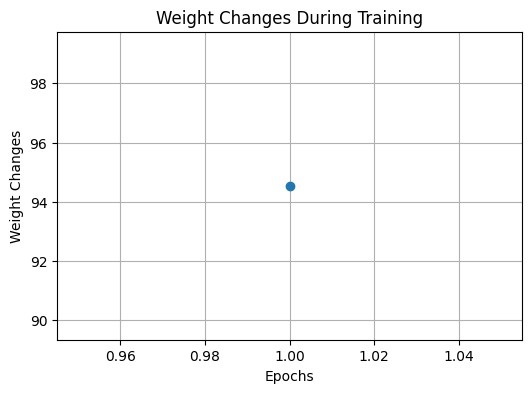

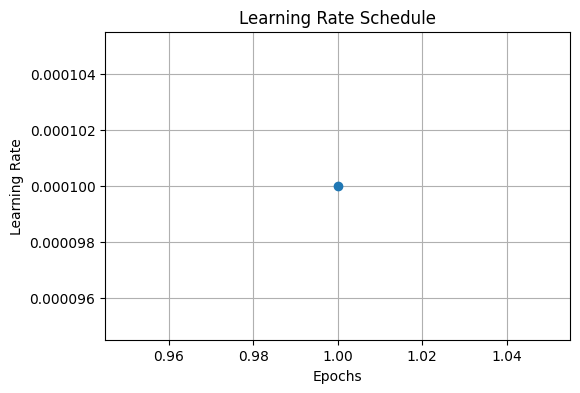

Epoch: 02
	Train Loss: -145.565 | Train Acc: 50.75%
	Validation Loss: -149.177 | Validation Acc: 51.61%


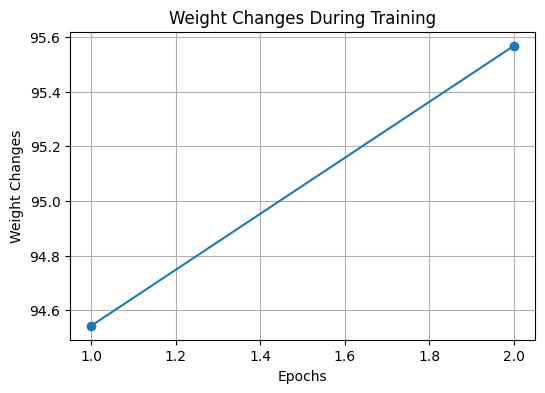

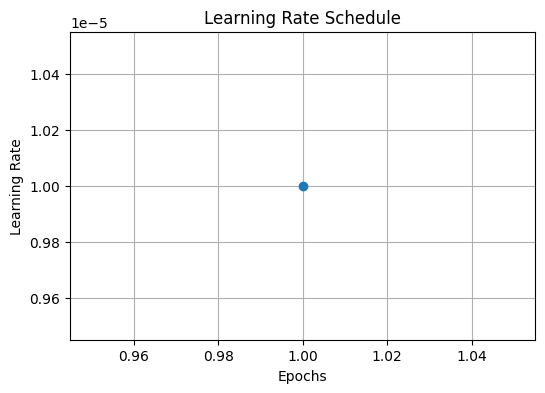

Epoch: 03
	Train Loss: -152.861 | Train Acc: 50.75%
	Validation Loss: -150.482 | Validation Acc: 51.61%


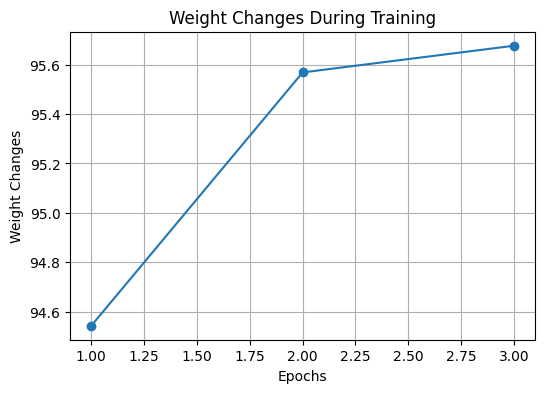

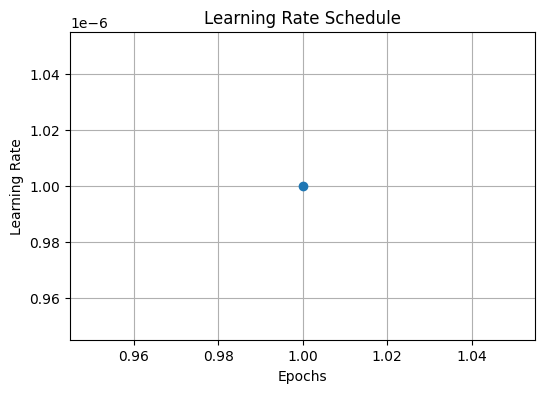

Epoch: 04
	Train Loss: -153.634 | Train Acc: 50.75%
	Validation Loss: -150.612 | Validation Acc: 51.61%


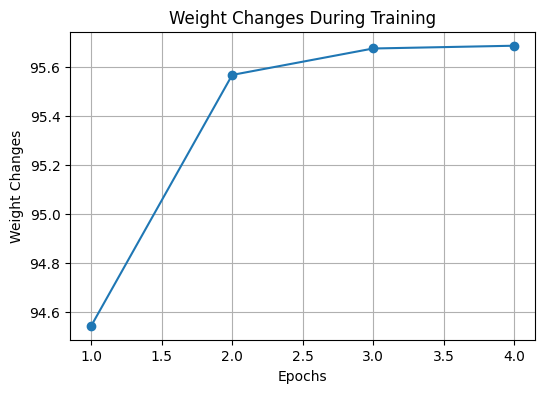

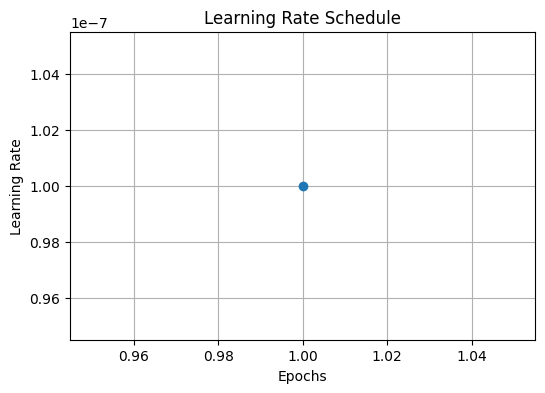

Epoch: 05
	Train Loss: -153.658 | Train Acc: 50.75%
	Validation Loss: -150.624 | Validation Acc: 51.61%


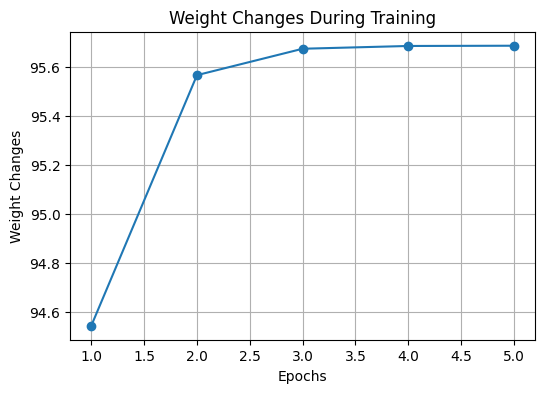

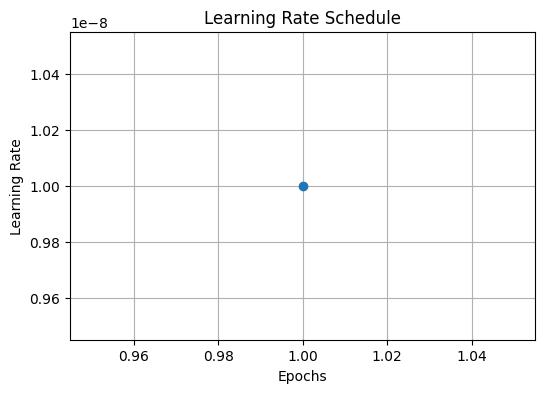

Test Loss: -152.926 | Test Acc: 51.07%


In [55]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

initial_params = [param.clone().detach() for param in model.parameters()]
weight_changes = []

# Training loop
for epoch in range(parameters['NUM_EPOCHS']):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, parameters['CLIP'], parameters['DEVICE'])
    valid_loss, valid_acc = evaluate(model, validation_loader, criterion,  parameters['DEVICE'])
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation Acc: {valid_acc*100:.2f}%')
    scheduler.step()

    current_params = [param.clone().detach() for param in model.parameters()]
    changes = calculate_weight_changes(model, initial_params)
    weight_changes.append(sum(changes))
    plot_weight_changes(weight_changes)

    plot_learning_rate(optimizer)

# Test the model
test_loss, test_acc = evaluate(model, test_loader, criterion,  parameters['DEVICE'])
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

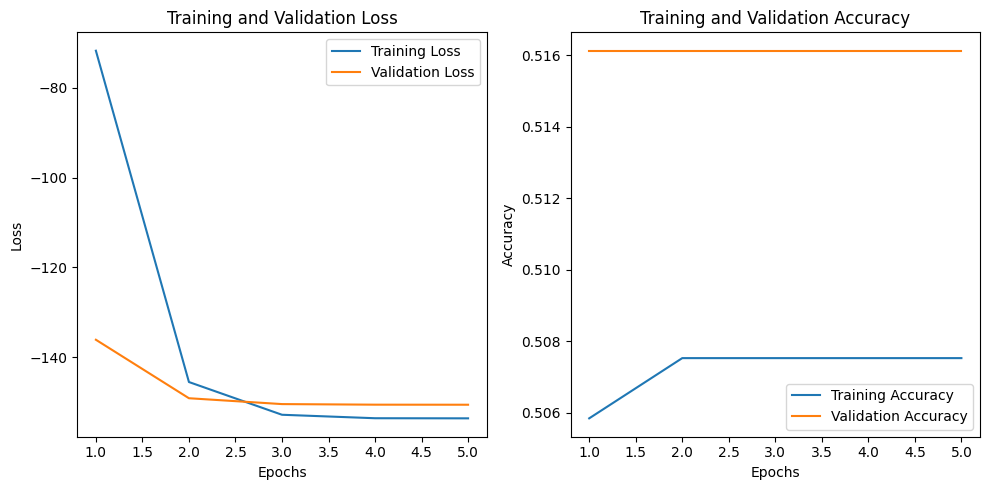

In [56]:
plot_curves(train_losses, valid_losses, train_accs, valid_accs)

In [57]:
file_path = 'bilstm.pth'
torch.save(model.state_dict(), file_path)
print("Model saved successfully.")

Model saved successfully.


* TODO: Try this model on the IMDB dataset